<a href="https://colab.research.google.com/github/iam-Srini/customer_churn/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the Libraries

In [763]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### **Model Class**

In [764]:
class Model:

  def __init__(self, model) -> None:
    self.model = model

  def train_model(self, X_train, y_train):
    self.model.fit(X_train, y_train)

  def predict_output(self, X_test):
    y_pred = self.model.predict(X_test)
    if hasattr(self.model, 'predict_proba'):
      y_prob = self.model.predict_proba(X_test)[:, 1]
    else:
      y_prob = self.model.decision_function(X_test)
    self.y_pred = y_pred
    self.y_prob = y_prob
    return y_pred, y_prob

  def model_results(self, y_test):
    accuracy = round(accuracy_score(y_test, self.y_pred),2)
    precision = round(precision_score(y_test, self.y_pred),2)
    recall = round(recall_score(y_test, self.y_pred),2)
    f1 = round(f1_score(y_test, self.y_pred),2)
    auc = round(roc_auc_score(y_test, self.y_prob),2)
    cm = confusion_matrix(y_test, self.y_pred)
    # Print the results
    return {
        "Accuracy": accuracy,
        "Precision":precision,
        "Recall": recall,
        "F1 Score":f1,
        "AUC":auc,
        "Confusion Matrix":cm

    }


Import the dataset

In [765]:
raw_data = pd.read_csv('TelcoCustomer.csv')

In [766]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [767]:
raw_data.replace({'Yes':1,'No':0}, inplace = True)

In [768]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [769]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [770]:
shuffled_raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [771]:
total_ones_count = 0

In [772]:
total_zeros_count = 0
zeros_list = []
ones_list = []

In [773]:
# Separate zeros and ones
for i in range(shuffled_raw_data.shape[0]):
    if shuffled_raw_data.iloc[i]['Churn'] == 0:
        zeros_list.append(shuffled_raw_data.iloc[i])
        total_zeros_count += 1
    else:
        ones_list.append(shuffled_raw_data.iloc[i])
        total_ones_count += 1

In [774]:
# Determine the number of samples to keep for balancing
min_count = min(total_zeros_count, total_ones_count)

# Sample and combine the data
balanced_zeros = zeros_list[:min_count]
balanced_ones = ones_list[:min_count]

In [775]:
# Create the balanced dataset
balanced_data = balanced_zeros + balanced_ones

# Convert balanced_data back to DataFrame
balanced_data_df = pd.DataFrame(balanced_data)

In [776]:
balanced_data_df = balanced_data_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [777]:
balanced_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3738 non-null   object 
 1   gender            3738 non-null   object 
 2   SeniorCitizen     3738 non-null   int64  
 3   Partner           3738 non-null   int64  
 4   Dependents        3738 non-null   int64  
 5   tenure            3738 non-null   int64  
 6   PhoneService      3738 non-null   int64  
 7   MultipleLines     3738 non-null   object 
 8   InternetService   3738 non-null   object 
 9   OnlineSecurity    3738 non-null   object 
 10  OnlineBackup      3738 non-null   object 
 11  DeviceProtection  3738 non-null   object 
 12  TechSupport       3738 non-null   object 
 13  StreamingTV       3738 non-null   object 
 14  StreamingMovies   3738 non-null   object 
 15  Contract          3738 non-null   object 
 16  PaperlessBilling  3738 non-null   int64  


In [778]:
balanced_data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,8065-QBYTO,Female,1,0,0,71,1,1,Fiber optic,1,1,0,1,1,0,One year,1,Credit card (automatic),99.65,7181.25,0
1,1346-UFHAX,Female,0,0,0,13,1,1,Fiber optic,1,0,0,0,0,0,Month-to-month,1,Credit card (automatic),80.00,1029.35,0
2,9483-GCPWE,Male,0,0,1,9,1,0,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,20.10,190.25,0
3,0178-CIIKR,Female,0,0,0,3,1,0,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,19.95,58,0
4,6242-SGYTS,Male,0,1,1,62,1,1,Fiber optic,1,1,0,0,1,0,One year,1,Credit card (automatic),94.95,5791.85,0


In [779]:
balanced_data_df['TotalCharges'] = pd.to_numeric(balanced_data_df['TotalCharges'], errors='coerce')

In [780]:
balanced_data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,8065-QBYTO,Female,1,0,0,71,1,1,Fiber optic,1,1,0,1,1,0,One year,1,Credit card (automatic),99.65,7181.25,0
1,1346-UFHAX,Female,0,0,0,13,1,1,Fiber optic,1,0,0,0,0,0,Month-to-month,1,Credit card (automatic),80.00,1029.35,0
2,9483-GCPWE,Male,0,0,1,9,1,0,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,20.10,190.25,0
3,0178-CIIKR,Female,0,0,0,3,1,0,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,19.95,58.00,0
4,6242-SGYTS,Male,0,1,1,62,1,1,Fiber optic,1,1,0,0,1,0,One year,1,Credit card (automatic),94.95,5791.85,0


In [781]:
balanced_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3738 non-null   object 
 1   gender            3738 non-null   object 
 2   SeniorCitizen     3738 non-null   int64  
 3   Partner           3738 non-null   int64  
 4   Dependents        3738 non-null   int64  
 5   tenure            3738 non-null   int64  
 6   PhoneService      3738 non-null   int64  
 7   MultipleLines     3738 non-null   object 
 8   InternetService   3738 non-null   object 
 9   OnlineSecurity    3738 non-null   object 
 10  OnlineBackup      3738 non-null   object 
 11  DeviceProtection  3738 non-null   object 
 12  TechSupport       3738 non-null   object 
 13  StreamingTV       3738 non-null   object 
 14  StreamingMovies   3738 non-null   object 
 15  Contract          3738 non-null   object 
 16  PaperlessBilling  3738 non-null   int64  


In [782]:
# Drop 'customerID' as it is just an identifier
balanced_data_df = balanced_data_df.drop('customerID', axis=1)

# Convert categorical variables to dummy/indicator variables
balanced_data_df = pd.get_dummies(balanced_data_df, drop_first=True)

In [783]:
balanced_data_df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,MultipleLines_1,MultipleLines_No phone service,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_1,TechSupport_No internet service,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_1,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,71,1,1,99.65,7181.25,0,False,True,False,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False
1,0,0,0,13,1,1,80.00,1029.35,0,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,0,0,1,9,1,0,20.10,190.25,0,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,True,False,False,False,True
3,0,0,0,3,1,0,19.95,58.00,0,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,True
4,0,1,1,62,1,1,94.95,5791.85,0,True,True,False,False,True,True,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [784]:
balanced_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          3738 non-null   int64  
 1   Partner                                3738 non-null   int64  
 2   Dependents                             3738 non-null   int64  
 3   tenure                                 3738 non-null   int64  
 4   PhoneService                           3738 non-null   int64  
 5   PaperlessBilling                       3738 non-null   int64  
 6   MonthlyCharges                         3738 non-null   float64
 7   TotalCharges                           3735 non-null   float64
 8   Churn                                  3738 non-null   int64  
 9   gender_Male                            3738 non-null   bool   
 10  MultipleLines_1                        3738 non-null   bool   
 11  Mult

In [785]:
balanced_data_df = balanced_data_df.dropna()

In [786]:
y = balanced_data_df['Churn']
X = balanced_data_df.drop('Churn', axis = 1)

In [787]:
# Convert boolean columns to integers
X = X.astype({col: 'int' for col in X.select_dtypes(include=['bool']).columns})

In [788]:
corr_matrix = X.corr()
high_corr = corr_matrix[(corr_matrix > 0.95) | (corr_matrix < -0.95)]
print(high_corr)

                                       SeniorCitizen  Partner  Dependents  \
SeniorCitizen                                    1.0      NaN         NaN   
Partner                                          NaN      1.0         NaN   
Dependents                                       NaN      NaN         1.0   
tenure                                           NaN      NaN         NaN   
PhoneService                                     NaN      NaN         NaN   
PaperlessBilling                                 NaN      NaN         NaN   
MonthlyCharges                                   NaN      NaN         NaN   
TotalCharges                                     NaN      NaN         NaN   
gender_Male                                      NaN      NaN         NaN   
MultipleLines_1                                  NaN      NaN         NaN   
MultipleLines_No phone service                   NaN      NaN         NaN   
InternetService_DSL                              NaN      NaN         NaN   

In [789]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X[['MonthlyCharges', 'TotalCharges']])

In [790]:
# Drop the high correlated columns to avoid multicollinearity
X.drop(columns=['StreamingMovies_No internet service','MultipleLines_No phone service','OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service'], inplace=True)


In [791]:
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Male,MultipleLines_1,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_1,DeviceProtection_1,TechSupport_1,StreamingTV_1,StreamingMovies_1,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,71,1,1,1.104467,2.350351,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0
1,0,0,0,13,1,1,0.421442,-0.466763,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,9,1,0,-1.660656,-0.851009,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,0,0,0,3,1,0,-1.665870,-0.911570,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,1,62,1,1,0.941097,1.714109,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0


In [792]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [793]:
logreg = LogisticRegression()
model = Model(logreg)
model.train_model(X_train, y_train)
y_pred, y_prob = model.predict_output(X_test)
results_log = model.model_results(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [794]:
# Random Forest Example
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf = Model(rf)
model_rf.train_model(X_train, y_train)
y_pred_rf, y_prob_rf = model_rf.predict_output(X_test)
results_rf = model_rf.model_results(y_test)

In [795]:
# SVM Example
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)
model_svm = Model(svm)
model_svm.train_model(X_train, y_train)
y_pred_svm, y_prob_svm = model_svm.predict_output(X_test)
results_svm = model_svm.model_results(y_test)

In [796]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb = Model(xgb_model)
model_xgb.train_model(X_train, y_train)
y_pred_xgb, y_prob_xgb = model_xgb.predict_output(X_test)
results_xgb = model_xgb.model_results(y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [797]:
print("Logistic Regression Results:")
print(results_log)
print("\nRandom Forest Results:")
print(results_rf)
print("\nSVM Results:")
print(results_svm)
print("\nXGBoost Results:")
print(results_xgb)

Logistic Regression Results:
{'Accuracy': 0.76, 'Precision': 0.72, 'Recall': 0.8, 'F1 Score': 0.76, 'AUC': 0.83, 'Confusion Matrix': array([[279, 111],
       [ 70, 287]])}

Random Forest Results:
{'Accuracy': 0.73, 'Precision': 0.71, 'Recall': 0.75, 'F1 Score': 0.73, 'AUC': 0.81, 'Confusion Matrix': array([[280, 110],
       [ 90, 267]])}

SVM Results:
{'Accuracy': 0.73, 'Precision': 0.7, 'Recall': 0.77, 'F1 Score': 0.74, 'AUC': 0.81, 'Confusion Matrix': array([[272, 118],
       [ 81, 276]])}

XGBoost Results:
{'Accuracy': 0.74, 'Precision': 0.71, 'Recall': 0.75, 'F1 Score': 0.73, 'AUC': 0.81, 'Confusion Matrix': array([[282, 108],
       [ 88, 269]])}


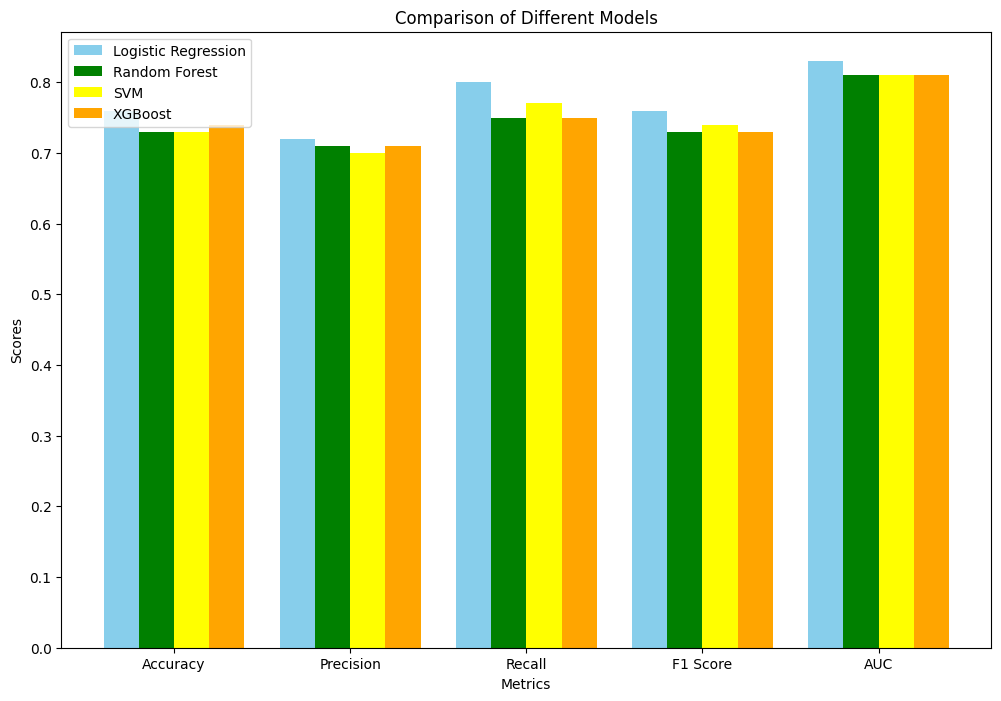

In [809]:
import matplotlib.pyplot as plt

# Extract metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
logreg_scores = [results_log[m] for m in metrics]
rf_scores = [results_rf[m] for m in metrics]
svm_scores = [results_svm[m] for m in metrics]
xgb_scores = [results_xgb[m] for m in metrics]

# Plot comparison
x = range(len(metrics))
plt.figure(figsize=(12, 8))
plt.bar(x, logreg_scores, width=0.2, label='Logistic Regression', align='center', color='skyblue')
plt.bar([p + 0.2 for p in x], rf_scores, width=0.2, label='Random Forest', align='center',color='green')
plt.bar([p + 0.4 for p in x], svm_scores, width=0.2, label='SVM', align='center', color='yellow')
plt.bar([p + 0.6 for p in x], xgb_scores, width=0.2, label='XGBoost', align='center',color='orange')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Different Models')
plt.xticks([p + 0.3 for p in x], metrics)
plt.legend()
plt.show()


In [799]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fpr, tpr, auc_score, label):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {auc_score:.2f})')


In [800]:
y_prob_logreg = model.y_prob
y_prob_rf = model_rf.y_prob
y_prob_svm = model_svm.y_prob
y_prob_xgb = model_xgb.y_prob

In [801]:
# Compute ROC curve data
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

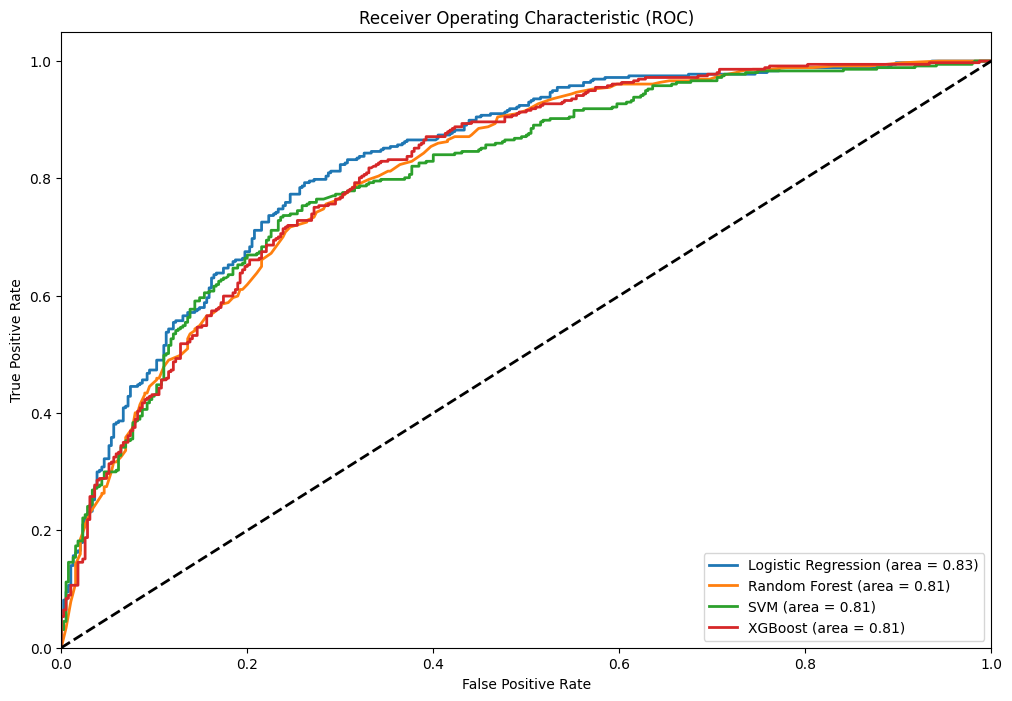

In [802]:

# Plot ROC curves
plt.figure(figsize=(12, 8))
plot_roc_curve(fpr_logreg, tpr_logreg, auc_logreg, 'Logistic Regression')
plot_roc_curve(fpr_rf, tpr_rf, auc_rf, 'Random Forest')
plot_roc_curve(fpr_svm, tpr_svm, auc_svm, 'SVM')
plot_roc_curve(fpr_xgb, tpr_xgb, auc_xgb, 'XGBoost')

# Add plot details
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()